<a href="https://colab.research.google.com/github/AzumaNoDoragon/IOT-with-IA/blob/main/IOT-with-IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Carregar o CSV baixado do ThingSpeak
df = pd.read_csv("cornelio_procopio_5dias_5min_preenchido.csv")

# Converter coluna de tempo
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', utc=True)

# Organizar pelo tempo (garantir ordem cronologica)
df = df.dropna(subset=['datetime'])
df = df.set_index('datetime').sort_index()

# Renomear colunas (ajuste se necessario)
df = df.rename(columns={'temperatura_C':'temperatura', 'umidade_rel_%':'umidade'})

# Converter strings em numeros
df['temperatura'] = pd.to_numeric(df['temperatura'], errors='coerce')
df['umidade']     = pd.to_numeric(df['umidade'], errors='coerce')

# Remover linhas invalidas
df = df.dropna(subset=['temperatura', 'umidade'])

print(df.head())

                           temperatura    umidade
datetime                                         
2025-09-12 00:00:00+00:00       20.400  41.000000
2025-09-12 00:05:00+00:00       20.325  41.416667
2025-09-12 00:10:00+00:00       20.250  41.833333
2025-09-12 00:15:00+00:00       20.175  42.250000
2025-09-12 00:20:00+00:00       20.100  42.666667


       temperatura      umidade
count  1573.000000  1573.000000
mean     22.901494    49.799746
std       4.862867    15.455542
min      14.200000    23.000000
25%      19.791667    36.000000
50%      22.166667    49.583333
75%      26.866667    63.083333
max      32.800000    78.000000


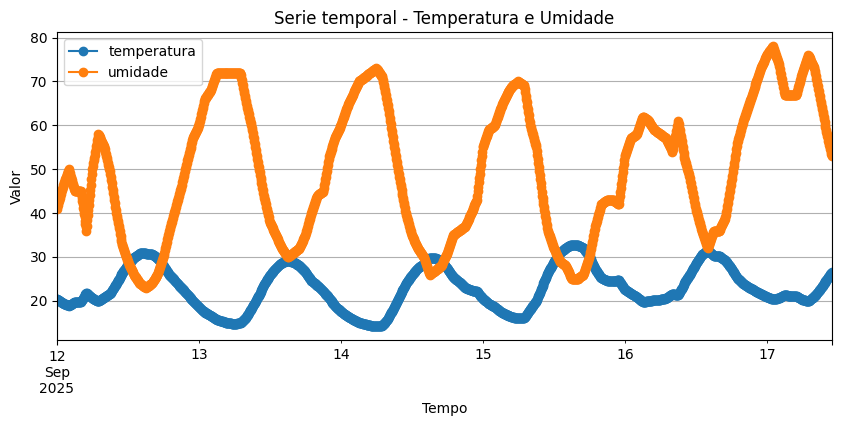

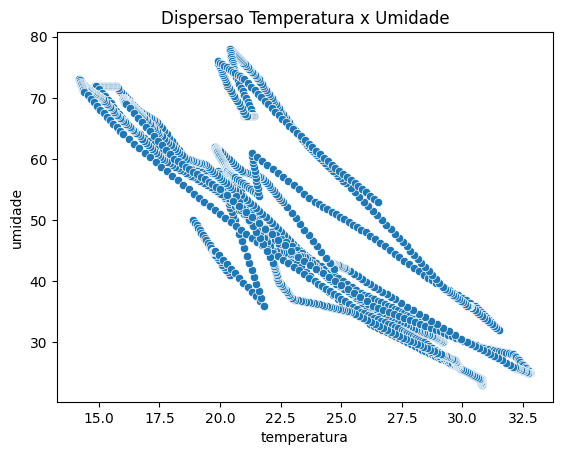

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estatisticas descritivas
print(df.describe())

# Serie temporal de temperatura e umidade
df[['temperatura', 'umidade']].plot(figsize=(10,4), marker='o')
plt.title("Serie temporal - Temperatura e Umidade")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

# Relacao entre temperatura e umidade
sns.scatterplot(x='temperatura', y='umidade', data=df)
plt.title("Dispersao Temperatura x Umidade")
plt.show()

In [ ]:
# Remover leituras invalidas (faixas plausiveis para ambiente)
df = df[(df['temperatura'].between(-20, 60)) &
        (df['umidade'].between(0, 100))]

print("Apos limpeza:", df.shape[0], "amostras")

Apos limpeza: 1573 amostras


In [ ]:
# Rotulo binario: 1 = confortavel, 0 = desconfortavel
df['conforto'] = ((df['temperatura'] < 28.0) &
                  (df['umidade'] > 40.0)).astype(int)

print(df[['temperatura','umidade','conforto']].head())

                           temperatura    umidade  conforto
datetime                                                   
2025-09-12 00:00:00+00:00       20.400  41.000000         1
2025-09-12 00:05:00+00:00       20.325  41.416667         1
2025-09-12 00:10:00+00:00       20.250  41.833333         1
2025-09-12 00:15:00+00:00       20.175  42.250000         1
2025-09-12 00:20:00+00:00       20.100  42.666667         1


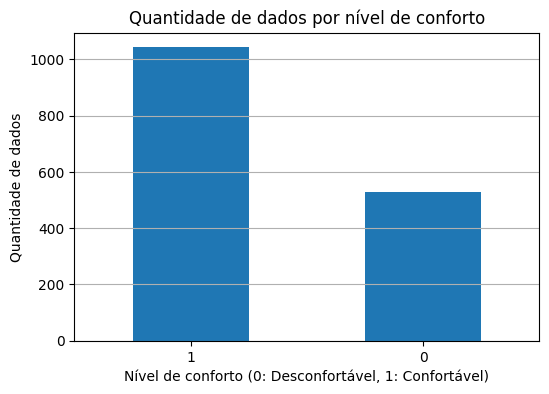

In [ ]:
import matplotlib.pyplot as plt

# Contar a quantidade de cada valor na coluna 'conforto'
conforto_counts = df['conforto'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(6, 4))
conforto_counts.plot(kind='bar')
plt.title("Quantidade de dados por nível de conforto")
plt.xlabel("Nível de conforto (0: Desconfortável, 1: Confortável)")
plt.ylabel("Quantidade de dados")
plt.xticks(rotation=0) # Para manter os rótulos do eixo x na horizontal
plt.grid(axis='y')
plt.show()

In [ ]:
# Atributo preditor
X_reg = df[['umidade']].values
# Variavel alvo
y_reg = df['temperatura'].values

In [ ]:
from sklearn.model_selection import train_test_split

# --- Classificacao ---
X_cls = df[['temperatura','umidade']].values
y_cls = df['conforto'].values

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# --- Regressao ---
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("Classificacao:", X_train_c.shape, "treino;", X_test_c.shape, "teste")
print("Regressao:", X_train_r.shape, "treino;", X_test_r.shape, "teste")

Classificacao: (1258, 2) treino; (315, 2) teste
Regressao: (1258, 1) treino; (315, 1) teste


Acuracia: 1.000

Relatorio de classificacao:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00       209

    accuracy                           1.00       315
   macro avg       1.00      1.00      1.00       315
weighted avg       1.00      1.00      1.00       315



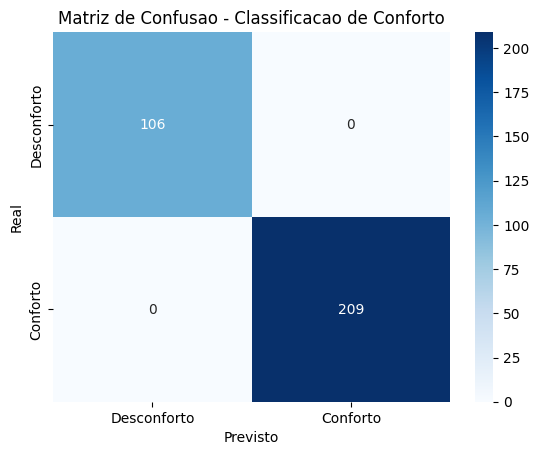

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Treinamento
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train_c, y_train_c)

# Predicao
y_pred_c = clf.predict(X_test_c)

# Metricas
acc = accuracy_score(y_test_c, y_pred_c)
print(f"Acuracia: {acc:.3f}")
print("\nRelatorio de classificacao:\n", classification_report(y_test_c, y_pred_c))

# Matriz de confusao
cm = confusion_matrix(y_test_c, y_pred_c)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Desconforto','Conforto'],
            yticklabels=['Desconforto','Conforto'])
plt.title("Matriz de Confusao - Classificacao de Conforto")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

In [ ]:
# Predicao
y_pred_c_1 = clf.predict([[27.1, 55]])
print(y_pred_c_1)

[1]


LinearRegression -> MAE: 1.94 | RMSE: 5.60
RandomForestRegressor -> MAE: 1.67 | RMSE: 5.17


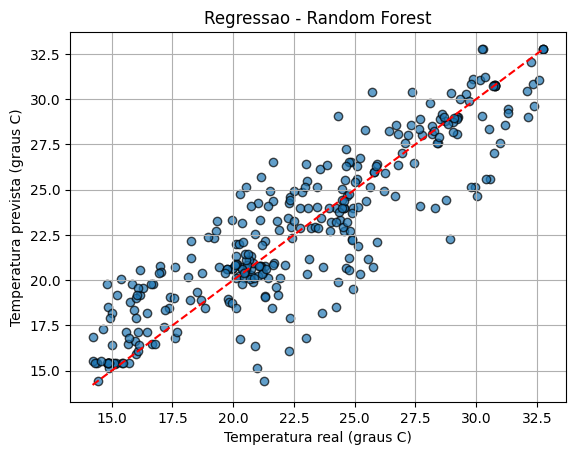

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Regressao Linear ---
linreg = LinearRegression()
linreg.fit(X_train_r, y_train_r)
y_pred_lin = linreg.predict(X_test_r)

mae_lin  = mean_absolute_error(y_test_r, y_pred_lin)
rmse_lin = mean_squared_error(y_test_r, y_pred_lin)
print(f"LinearRegression -> MAE: {mae_lin:.2f} | RMSE: {rmse_lin:.2f}")

# --- Random Forest Regressor ---
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(X_train_r, y_train_r)
y_pred_rfr = rfr.predict(X_test_r)

mae_rfr  = mean_absolute_error(y_test_r, y_pred_rfr)
rmse_rfr = mean_squared_error(y_test_r, y_pred_rfr)
print(f"RandomForestRegressor -> MAE: {mae_rfr:.2f} | RMSE: {rmse_rfr:.2f}")

# Visualizacao: valores reais vs previstos (Random Forest)
plt.scatter(y_test_r, y_pred_rfr, alpha=0.7, edgecolors='k')
plt.xlabel("Temperatura real (graus C)")
plt.ylabel("Temperatura prevista (graus C)")
plt.title("Regressao - Random Forest")
plt.plot([min(y_test_r), max(y_test_r)], [min(y_test_r), max(y_test_r)], 'r--')
plt.grid(True)
plt.show()

In [ ]:
print(rfr.predict([[25]]))

[32.74642682]


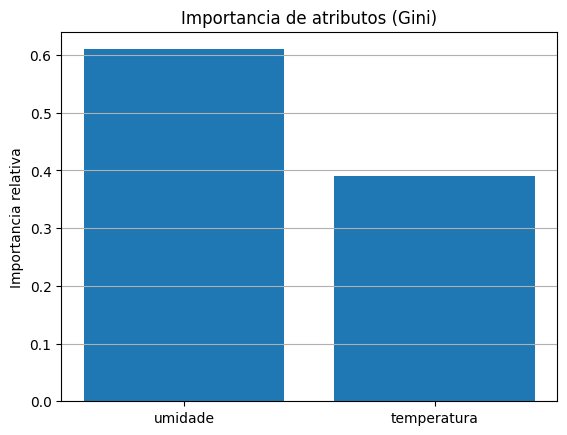

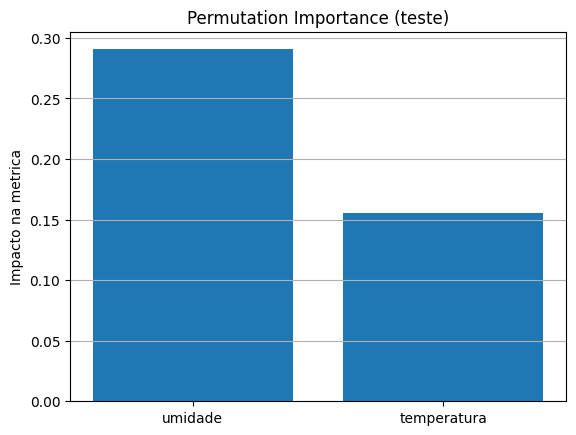

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Importancias por impureza (Gini)
importancias = clf.feature_importances_
nomes = ['temperatura', 'umidade']
ordem = np.argsort(importancias)[::-1]

plt.bar(range(len(nomes)), importancias[ordem], tick_label=np.array(nomes)[ordem])
plt.title("Importancia de atributos (Gini)")
plt.ylabel("Importancia relativa")
plt.grid(True, axis='y')
plt.show()

# Permutation Importance:
perm = permutation_importance(clf, X_test_c, y_test_c, n_repeats=20, random_state=42)
imp_perm = perm.importances_mean
ordem_p = np.argsort(imp_perm)[::-1]

plt.bar(range(len(nomes)), imp_perm[ordem_p], tick_label=np.array(nomes)[ordem_p])
plt.title("Permutation Importance (teste)")
plt.ylabel("Impacto na metrica")
plt.grid(True, axis='y')
plt.show()

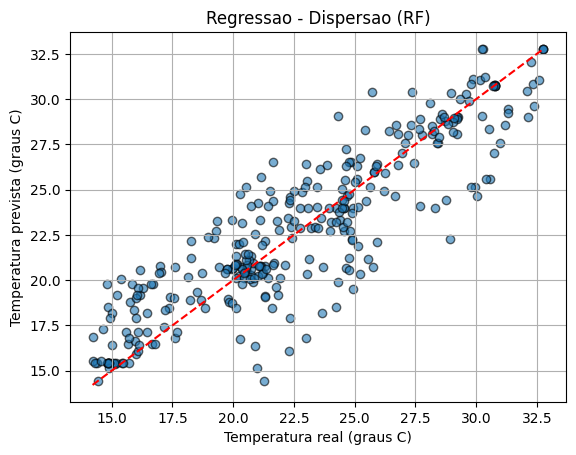

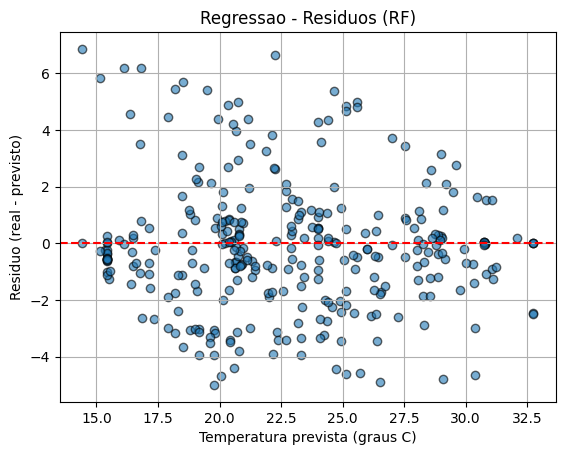

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dispersao: real vs previsto (Random Forest)
plt.scatter(y_test_r, y_pred_rfr, alpha=0.6, edgecolor='k')
minv, maxv = min(y_test_r.min(), y_pred_rfr.min()), max(y_test_r.max(), y_pred_rfr.max())
plt.plot([minv, maxv], [minv, maxv], 'r--')
plt.xlabel("Temperatura real (graus C)")
plt.ylabel("Temperatura prevista (graus C)")
plt.title("Regressao - Dispersao (RF)")
plt.grid(True)
plt.show()

# Residuos
res = y_test_r - y_pred_rfr
plt.scatter(y_pred_rfr, res, alpha=0.6, edgecolor='k')
plt.axhline(0.0, color='r', linestyle='--')
plt.xlabel("Temperatura prevista (graus C)")
plt.ylabel("Residuo (real - previsto)")
plt.title("Regressao - Residuos (RF)")
plt.grid(True)
plt.show()

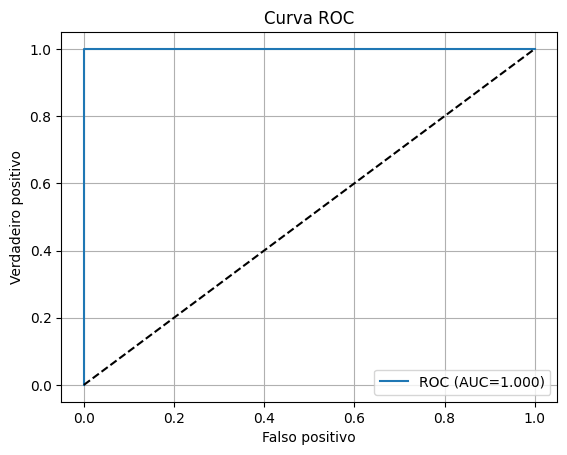

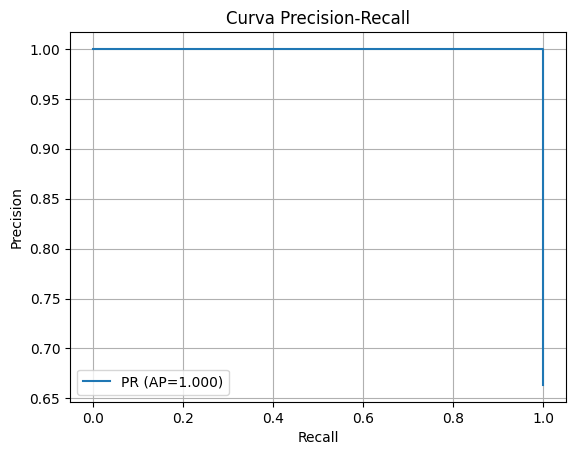

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Probabilidade da classe positiva (conforto=1)
y_proba = clf.predict_proba(X_test_c)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(y_test_c, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Falso positivo")
plt.ylabel("Verdadeiro positivo")
plt.title("Curva ROC")
plt.legend(); plt.grid(True); plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_test_c, y_proba)
ap = average_precision_score(y_test_c, y_proba)
plt.plot(rec, prec, label=f"PR (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend(); plt.grid(True); plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib

# Exemplo (classificacao): scaler + RF
pipe_cls = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42))
])
pipe_cls.fit(X_train_c, y_train_c)

# Avaliacao rapida:
print("Acuracia (Pipeline):", pipe_cls.score(X_test_c, y_test_c))

# Persistir
joblib.dump(pipe_cls, "pipeline_classificacao_rf.joblib")

# Carregar e usar
loaded_cls = joblib.load("pipeline_classificacao_rf.joblib")
print("Acuracia (recarregado):", loaded_cls.score(X_test_c, y_test_c))

Acuracia (Pipeline): 1.0
Acuracia (recarregado): 1.0
